In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [18]:
df = pd.read_csv('Data/Boston.csv')
print(df.shape)
df.head()

(506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


<div>
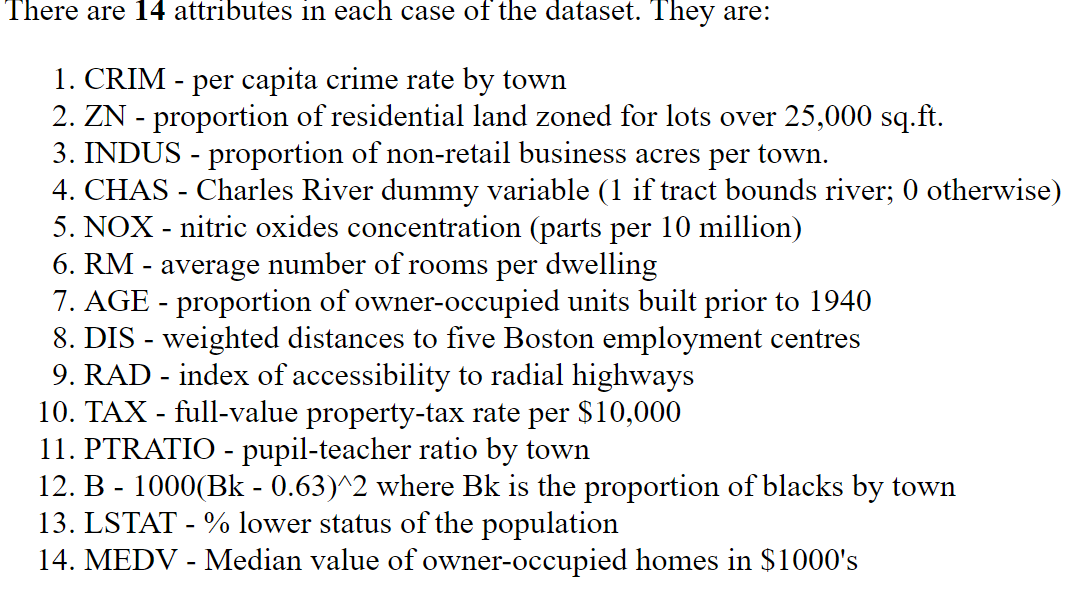
</div>

### Estimating $\hat{medv}$

22.532806324110677 0.40886114749753505


<AxesSubplot:ylabel='Count'>

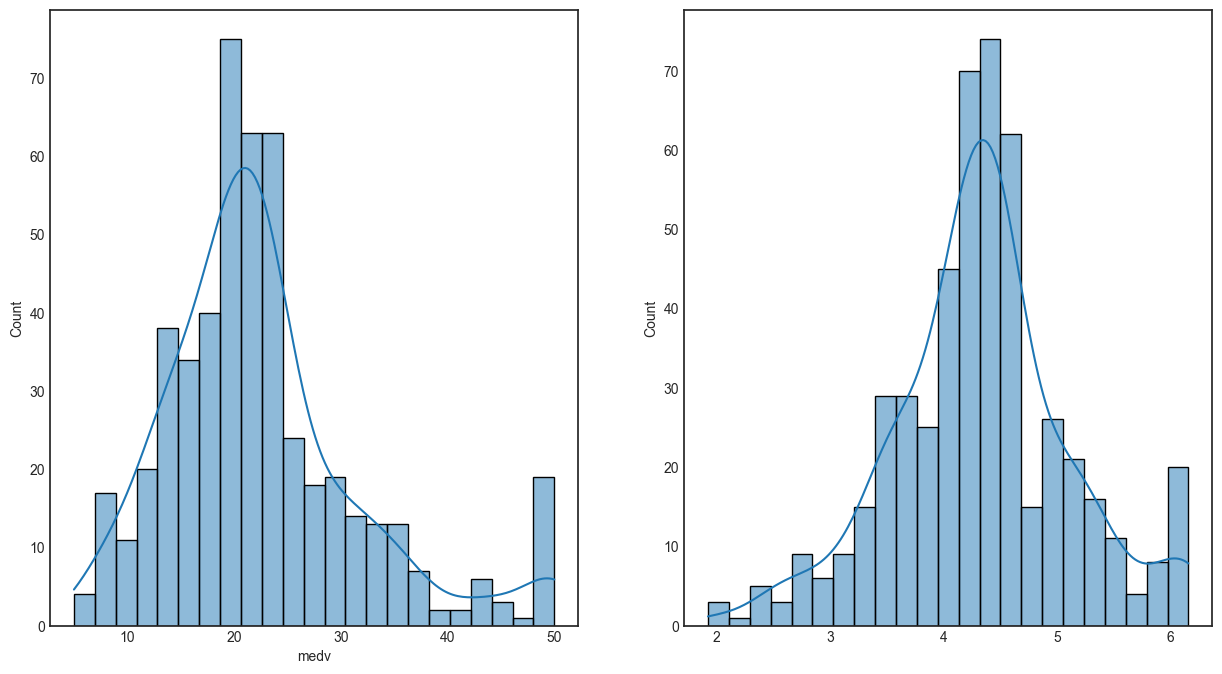

In [81]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

mean_hat = df["medv"].mean()
# n is bid enough to omit the correction
std_hat = df["medv"].std()/np.sqrt(df.shape[0])
print(mean_hat , std_hat)
                                   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
sns.histplot(x=df["medv"], kde=True, ax=ax1)
sns.histplot(x=boxcox(df["medv"])[0], kde=True, ax=ax2)

The data is not normally distributed, so SE

In [68]:
B = 1000

means = []
for k in range(B):
    # resample
    index_resamp_k = np.random.choice(df.index, size=df.shape[0])
    mean_k = df.loc[index_resamp_k, "medv"].mean()
    means.append(mean_k)

    
mean = pd.Series(means)
mean.agg(["mean", "std"])

mean    22.525730
std      0.418909
dtype: float64

Observation:
- the bootstrap mean is essentially the same as the sample mean. This is because sample mean is unbiased. </br>
- the bootstrapped std is comparable to the one obtained from the initial sample.
</br></br>
Next, to construct the confidence interval for $\hat{\mu}$, we can: 
- use the t-test, relying on the CLT (since `medv` is not normally distributed)
- bootstrap the conf interval

The boostrap interval is directly accesible:

In [74]:
mean.quantile(0.025), mean.quantile(0.975)

(21.66570158102767, 23.29607213438735)

In [101]:
from scipy.stats import t

half_l = t.ppf(0.975, df=df.shape[0]-1)*std_hat
mean_hat - half_l, df["medv"].mean() + half_l

(21.729528014578595, 23.33608463364276)

### Estimating median `medv`
This time the situation is more complicated. </br>
There are formulas for the SD of the sample median, but they are rather complicated. </br>

Bootstrap makes it much easier:

In [108]:
B = 1000

res = {"median" : [], "quant10": []}
for k in range(B):
    # resample
    index_resamp_k = np.random.choice(df.index, size=df.shape[0])
    median_k = df.loc[index_resamp_k, "medv"].median()
    quant10_k = df.loc[index_resamp_k, "medv"].quantile(0.1)
    res["median"].append(median_k)
    res["quant10"].append(quant10_k)
    
res = pd.DataFrame(res)
res.agg(["mean", "std"])

,median,quant10
mean,21.185050,12.765900
std,0.377646,0.490885


In [110]:
df["medv"].quantile(0.5), df["medv"].quantile(0.1)

(21.2, 12.75)